# N2200 in situ blade coating

### Import python libraries

In [1]:
# numpy and plotting
import numpy as np
from scipy.signal import convolve2d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'Arial',
                 'font.size': 10
                })
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 96

# Data handling
import os
import glob
import pandas as pd

# pyFAI
import pyFAI
from pyFAI.multi_geometry import MultiGeometry
from pyFAI.calibrant import get_calibrant
# from pyFAI.gui import jupyter

# pygix
import pygix
import fabio
from pygix import plotting as ppl

# Peak Fitting
from lmfit.models import GaussianModel, LorentzianModel, ExponentialModel, ConstantModel, LinearModel, VoigtModel

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load data files

Also define fundamental constants for this experiment

In [2]:
run_name = 'n22tol20_hi_para_1'

tiff_folder = "F:\\N2200 Project\\data\\chess_apr18\\{}".format(run_name)
waxs_glob = glob.glob(os.path.join(tiff_folder, "*.tiff"))
uv_straight = glob.glob("F:\\N2200 Project\\data\\chess_apr18\\wli\\{}\\straight\\*.txt".format(run_name))
uv_kicked = glob.glob("F:\\N2200 Project\\data\\chess_apr18\\wli\\{}\\kicked\\*.txt".format(run_name))

figfolder = tiff_folder.replace('data','figures')
os.makedirs(os.path.join(figfolder,'raw_waxs'),exist_ok=True)
os.makedirs(os.path.join(figfolder,'raw_uv'),exist_ok=True)

xray_dt = 0.2  # 0.2s per xray image
uv_dt = 0.1    # 0.1s per UV acquisition

## Parse file names and build master dataframe for results

These all followed the same alignment and run scripts, so we can write lists of thetas and exposure times that correspond to the movie numbers

In [3]:
def parse_filename(file):
    
    parts = file.split('_')
    parsed = pd.Series()
    
    parsed['solvent'] = parts[0]
    parsed['speed'] = parts[1]
    parsed['grooves'] = parts[2]
    parsed['repeat'] = parts[3]
    parsed['movie_num'] = int(parts[4])
    parsed['shot_num'] = int(parts[5][:-5])
    
    thetas = [0.12, 0.12, 0.12, 0.12, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.12]
    exp_times = [0.1, 0.1, 3, 0.2, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5]
    
    parsed['theta'] = thetas[parsed['movie_num']]
    parsed['exp_time'] = exp_times[parsed['movie_num']]
        
    return parsed

In [4]:
df = pd.DataFrame()
df['fullpath'] = pd.Series(waxs_glob)
df['filename'] = pd.Series([s[-1] for s in df['fullpath'].str.split('\\')])
df = pd.concat([df, df['filename'].apply(parse_filename)],
                      axis=1)
df

,fullpath,filename,solvent,speed,grooves,repeat,movie_num,shot_num,theta,exp_time
0,F:\N2200 Project\data\chess_apr18\n22tol20_hi_...,n22tol20_hi_para_1_10_0000.tiff,n22tol20,hi,para,1,10,0,0.12,3.5
1,F:\N2200 Project\data\chess_apr18\n22tol20_hi_...,n22tol20_hi_para_1_1_0000.tiff,n22tol20,hi,para,1,1,0,0.12,0.1
2,F:\N2200 Project\data\chess_apr18\n22tol20_hi_...,n22tol20_hi_para_1_2_0000.tiff,n22tol20,hi,para,1,2,0,0.12,3.0
3,F:\N2200 Project\data\chess_apr18\n22tol20_hi_...,n22tol20_hi_para_1_3_0000.tiff,n22tol20,hi,para,1,3,0,0.12,0.2
4,F:\N2200 Project\data\chess_apr18\n22tol20_hi_...,n22tol20_hi_para_1_3_0001.tiff,n22tol20,hi,para,1,3,1,0.12,0.2
5,F:\N2200 Project\data\chess_apr18\n22tol20_hi_...,n22tol20_hi_para_1_3_0002.tiff,n22tol20,hi,para,1,3,2,0.12,0.2
6,F:\N2200 Project\data\chess_apr18\n22tol20_hi_...,n22tol20_hi_para_1_3_0003.tiff,n22tol20,hi,para,1,3,3,0.12,0.2
7,F:\N2200 Project\data\chess_apr18\n22tol20_hi_...,n22tol20_hi_para_1_3_0004.tiff,n22tol20,hi,para,1,3,4,0.12,0.2
8,F:\N2200 Project\data\chess_apr18\n22tol20_hi_...,n22tol20_hi_para_1_3_0005.tiff,n22tol20,hi,para,1,3,5,0.12,0.2
9,F:\N2200 Project\data\chess_apr18\n22tol20_hi_...,n22tol20_hi_para_1_3_0006.tiff,n22tol20,hi,para,1,3,6,0.12,0.2


### Load example file for exploratory analysis

In [5]:
sample = 602
dark_movie = 2
main_movie = 3
dual_movie = 10
aoi_start = 4

data_file = df['fullpath'].loc[sample]
data_exp = df['exp_time'].loc[sample]
data = fabio.open(data_file).data
data = np.flipud(data)
dark_file = df.query('movie_num == {}'.format(dark_movie)).iloc[0]['fullpath']
dark_exp = df.query('movie_num == {}'.format(dark_movie)).iloc[0]['exp_time']
dark = np.flipud(fabio.open(dark_file).data)
darkscale = (data_exp/dark_exp)*dark

## Show raw detector data in log scale

<IPython.core.display.Javascript object>


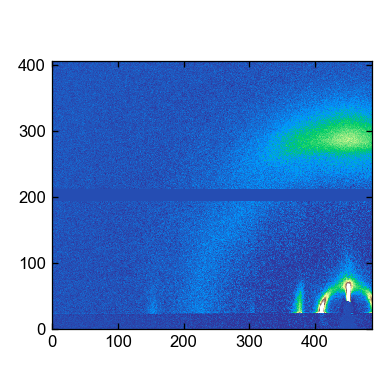

In [6]:
%matplotlib notebook

corrdata = data - darkscale
logdata = np.log(corrdata-np.min(corrdata)+1)

lmin, lmax = np.percentile(logdata, (2, 99.9))
plt.figure()
plt.imshow(logdata,cmap='terrain',vmin=lmin,vmax=lmax,origin='lower')

## Define pyFAI detector parameters

In [7]:
### Detector pixel size
det_pix = [172e-6, 172e-6]

detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

### Wavelength
wl = 0.97e-10

### Center-pixel and sample-to-detector distance
centerx =  448.248
centery = data.shape[0]-381.901   # This is because I had to flip it upside-down
sdd = 179.284e-3

### Beamcenter from sample view in meters from lower left of detector
poni1 = centery * det_pix[1]; poni2 = centerx * det_pix[0]

### detector rotations from sample view
rot1 = 0.0    /180 * np.pi # move detector to right, in-plane angle# in radians
rot2 = 0.0    /180 * np.pi # move detector down, out-of-plane angle
rot3 = 0.0    /180 * np.pi # clockwise rotation

# Orientations and Angles
sample_orientation = 1    # 1 is horizontal, 2 is vertical
incident_angle = df['theta'].loc[sample]     # indicent angle in deg
tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")

## Setup detector and sample geometry, Get qxy-qz data

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\pygix-0.1.4a0-py3.6.egg\pygix\plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


<IPython.core.display.Javascript object>


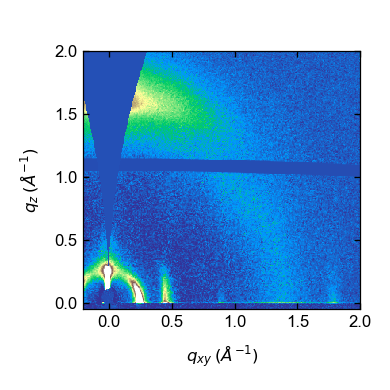

(<matplotlib.figure.Figure at 0xbff0c50>,
 <matplotlib.axes._subplots.AxesSubplot at 0xbff1a58>)

In [8]:
pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)

imgt, qxy, qz = pg.transform_reciprocal(data, method='lut', correctSolidAngle=True, unit='A', dark=darkscale)
corrimg = imgt-np.min(imgt)+1
logimg = np.log(corrimg)

clim = np.percentile(logimg, (2.5, 99.8))
ppl.implot(logimg, qxy, qz, mode='rsma', cmap="terrain", clim=clim, xlim=(-0.2,2), ylim=(-0.05,2))

## Peep the nice dual image

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\pygix-0.1.4a0-py3.6.egg\pygix\plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


<IPython.core.display.Javascript object>


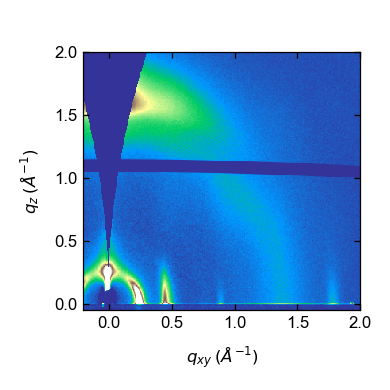

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


(<matplotlib.figure.Figure at 0xbb5c908>,
 <matplotlib.axes._subplots.AxesSubplot at 0xbb55588>)

In [9]:
dual_file = os.path.join(os.path.split(figfolder)[0],'{}_dual.png'.format(run_name))

dual_tiff = df['fullpath'].loc[df['movie_num']==dual_movie].iloc[0]
dual_exp = df['exp_time'].loc[df['movie_num']==dual_movie].iloc[0]
dual_data = fabio.open(dual_tiff).data
dual_data = np.flipud(dual_data)
darkscale_dual = (dual_exp/dark_exp)*dark

pg2 = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)

dualt, qxy, qz = pg2.transform_reciprocal(dual_data, method='lut', correctSolidAngle=True, unit='A', dark=darkscale_dual)
corrdual = dualt-np.min(dualt)+1
logdual = np.log(corrdual)

clim = np.percentile(logdual, (2.5, 99.8))
ppl.implot(logdual, qxy, qz, mode='rsma', cmap="terrain",
           clim=clim, xlim=(-0.2,2), ylim=(-0.05,2),
           filename=dual_file)

## Look at the AOI series

<IPython.core.display.Javascript object>


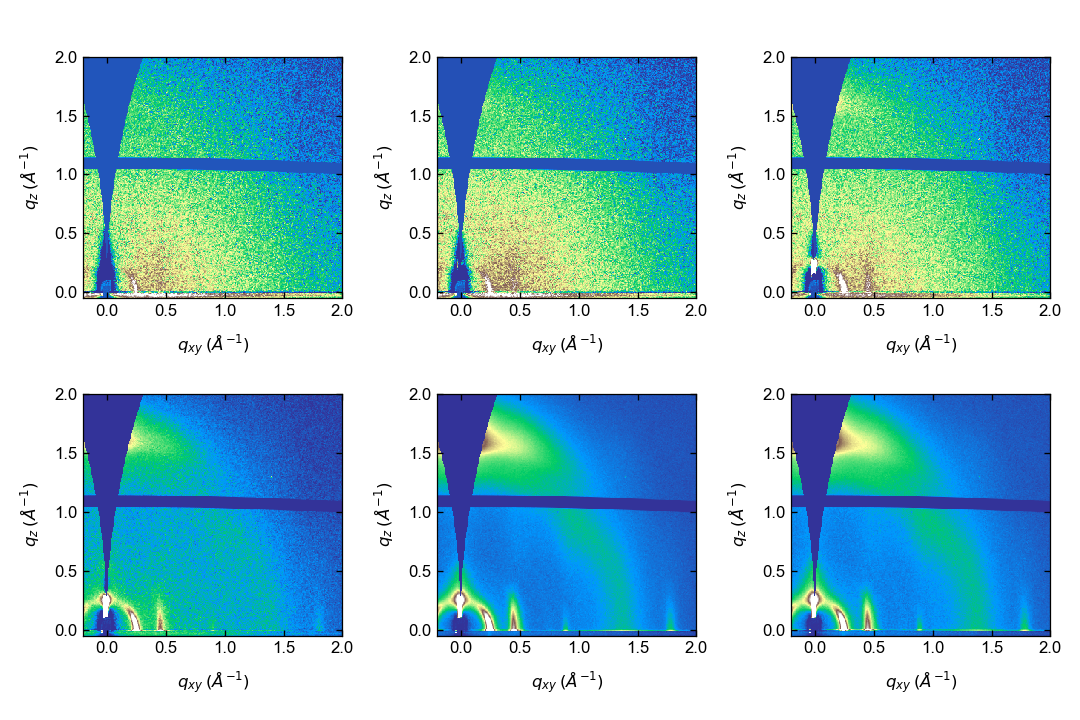

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\pygix-0.1.4a0-py3.6.egg\pygix\plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


In [10]:
plt.figure(figsize=(9,6))
aoi_file = os.path.join(os.path.split(figfolder)[0],'{}_aoi_series.png'.format(run_name))

for i in range(6):
    
    temp_movie_num = i + aoi_start
    aoi_tiff = df['fullpath'].loc[df['movie_num']==temp_movie_num].iloc[0]
    aoi_exp = df['exp_time'].loc[df['movie_num']==temp_movie_num].iloc[0]
    aoi_data = fabio.open(aoi_tiff).data
    aoi_data = np.flipud(aoi_data)
    darkscale_aoi = (aoi_exp/dark_exp)*dark

    pg3 = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                         rot1 = rot1, rot2 = rot2, rot3 = rot3,
                         wavelength = wl, sample_orientation = sample_orientation,
                         incident_angle = incident_angle, tilt_angle = tilt_angle,
                         detector=detector)

    aoit, qxy, qz = pg3.transform_reciprocal(aoi_data, method='lut', correctSolidAngle=True, unit='A', dark=darkscale_aoi)
    corraoi = aoit-np.min(aoit)+1
    logaoi = np.log(corraoi)
    
    clim = np.percentile(logaoi, (2.5, 99.8))
    plt.subplot(2,3,i+1)
    ppl.implot(logaoi, qxy, qz, mode='rsma', cmap="terrain",
               clim=clim, xlim=(-0.2,2), ylim=(-0.05,2),
               newfig=False)
    
plt.savefig(aoi_file)

## Get out-of-plane sector

Then do this for all runs and plot vs. time

<IPython.core.display.Javascript object>


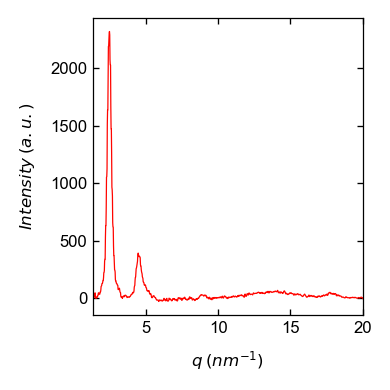

In [11]:
%matplotlib notebook
int_sect, q_sect = pg.profile_sector(data, npt=1000, chi_pos=86,
                                 chi_width=4, radial_range=(1.35, 20),
                                 correctSolidAngle=True,
                                 method='lut', dark=darkscale)
ppl.plot(q_sect,int_sect, logy=False)

In [12]:
df['sect86'] = df['fullpath'].apply(lambda f:
                                    pg.profile_sector(
                                        np.flipud(fabio.open(f).data), npt=1000, chi_pos=86,
                                         chi_width=4, radial_range=(1.35, 20),
                                         correctSolidAngle=True,
                                         method='lut', dark=darkscale)[0]
                                   )

sect_array = np.array(df.loc[df['movie_num']==main_movie]['sect86'].tolist())
log_sect_array = np.log(sect_array-np.min(sect_array)+1)
log_sect_array.shape

(600, 1000)

<IPython.core.display.Javascript object>


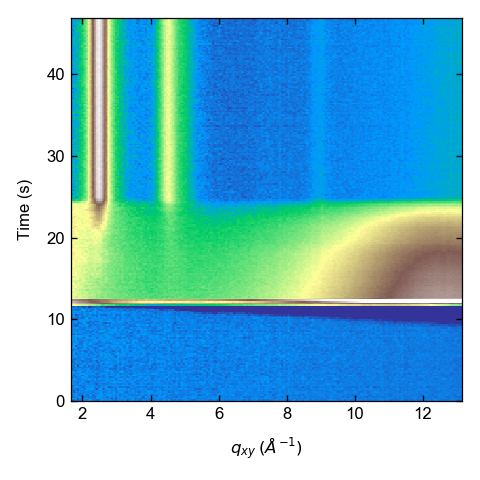

Text(0,0.5,'Time (s)')

In [14]:
%matplotlib notebook

xray_start = 0; xray_stop = log_sect_array.shape[0];
log_sect_crop = log_sect_array[xray_start:xray_stop,:]
vminx, vmaxx = np.percentile(log_sect_array, (2.5, 99.8))
extent_xray = [q_sect[0], q_sect[-1], 0, (xray_stop-xray_start)/5]

plt.figure(figsize=(4,4))
plt.imshow(log_sect_crop,
            origin='lower', aspect='auto',
            vmin=vminx, vmax=vmaxx,
            interpolation='nearest',
            cmap='terrain',
            extent=extent_xray)

plt.xlabel(r'$q_{xy} \: (\AA^{-1})$')
plt.ylabel('Time (s)')

### At what time does the blade pass? And when is the spectrum stable?

In [48]:
xray_blade_pass = 12.4  # What time is first spectrum after blade pass
xray_stable = 30        # What time is the spectrum stable for a while

xray_start = int(np.round(xray_blade_pass / xray_dt))
xray_stop = int(np.round(xray_stable / xray_dt))

log_sect_crop = log_sect_array[xray_start:xray_stop,:]
vminx, vmaxx = np.percentile(log_sect_array, (2.5, 99.8))
extent_xray = [q_sect[0], q_sect[-1], 0, (xray_stop-xray_start)/5]

print('set xray_start to: {}'.format(xray_start))
print('set xray_stop to: {}'.format(xray_stop))

set xray_start to: 62
set xray_stop to: 150


## Great, now let's work on the UV

We're going to do an average filter on the straight channel to smooth it out.

In [19]:
straight0 = np.loadtxt(uv_straight[0], skiprows=17, comments='>')
waves = straight0[:,0]
straight_raw = np.array([np.transpose(np.loadtxt(tt,skiprows=17,comments='>')[:,1]) for tt in uv_straight])
straight_raw.shape

(1200, 2048)

In [20]:
smoothing = 7

straight_array = convolve2d(straight_raw,
                            np.ones((1,smoothing))/smoothing,
                            mode = 'same')

In [21]:
kicked_array = np.array([np.transpose(np.loadtxt(tt,skiprows=17,comments='>')[:,1]) for tt in uv_kicked])
kicked_array.shape

(1195, 2048)

### Plot example spectra

<IPython.core.display.Javascript object>


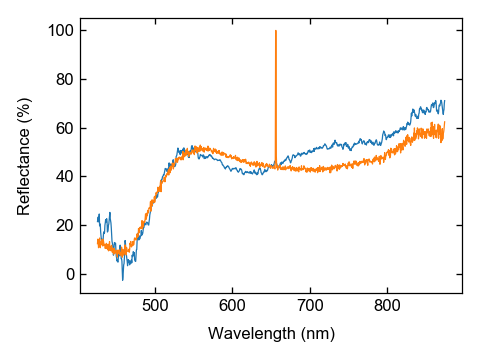

Text(0,0.5,'Reflectance (%)')

In [22]:
w_start = 425; w_stop = 875
w_start_ind = np.where(waves>w_start)[0][0]
w_stop_ind = np.where(waves>w_stop)[0][0]
waves_crop = waves[w_start_ind:w_stop_ind]

%matplotlib notebook
plt.figure(figsize=(4,3))
plt.plot(waves_crop,straight_array[-1,w_start_ind:w_stop_ind],
         waves_crop,kicked_array[-1,w_start_ind:w_stop_ind])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%)')

## Find the spectrum where you'll start t=0

<IPython.core.display.Javascript object>


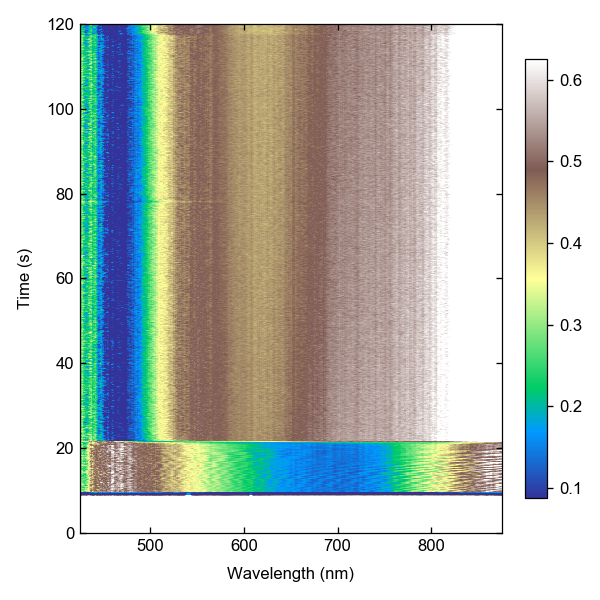

In [52]:
%matplotlib notebook

spec_start = 0; spec_stop = straight_array.shape[0];
straight_crop = straight_array[spec_start:spec_stop,w_start_ind:w_stop_ind].clip(min=0.1,max=100)/100

vmins, vmaxs = np.percentile(straight_crop, (2.5, 99.8))
extent_wli = [waves[w_start_ind], waves[w_stop_ind], 0, (spec_stop-spec_start)/10]

plt.figure(figsize=(5,5))
plt.imshow(straight_crop,
                origin='lower', aspect='auto',
                vmin=vmink, vmax=vmaxk,
                interpolation='nearest',
                cmap='terrain',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Time (s)')
plt.colorbar(fraction=0.047, pad=0.05).ax.tick_params(axis='y', direction='out')

### At what time does the blade pass? Then calculate stop frame from xray stop frame

In [53]:
uv_blade_pass = 9.6  # What time is first spectrum after blade pass

spec_start = int(np.round(uv_blade_pass / uv_dt))
spec_stop = int(np.round( (uv_blade_pass + (xray_stop-xray_start)*xray_dt) / uv_dt))

print('set spec_start to: {}'.format(spec_start))
print('set spec_stop to: {}'.format(spec_stop))

set spec_start to: 96
set spec_stop to: 272


## Plot the straight and kicked spectra side-by-side

We can also nudge the kicked spectrum around a bit to fix any remaining offset

<IPython.core.display.Javascript object>


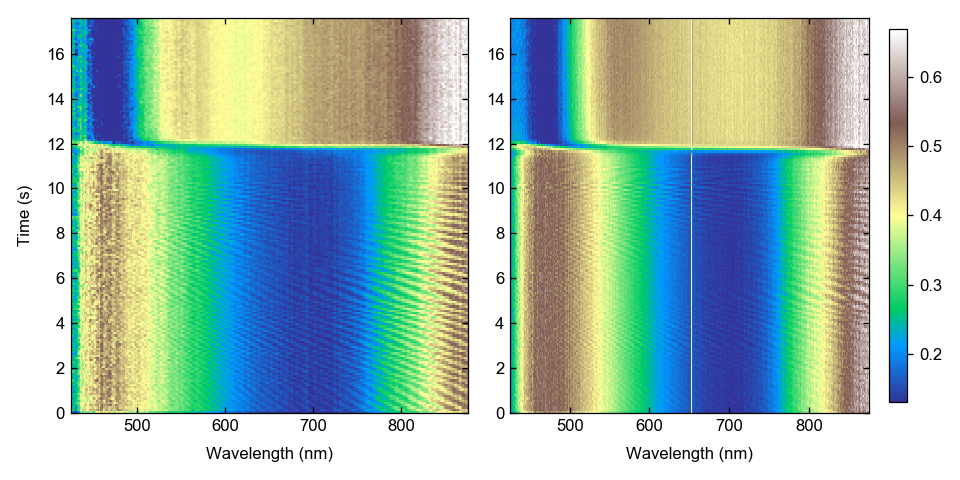

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [54]:
%matplotlib notebook

kickoff = -5

straight_crop = straight_array[spec_start:spec_stop,w_start_ind:w_stop_ind].clip(min=0.1,max=100)/100
kicked_crop = kicked_array[spec_start+kickoff:spec_stop+kickoff,w_start_ind:w_stop_ind].clip(min=0.1,max=100)/100

vmins, vmaxs = np.percentile(straight_crop, (2.5, 99.8))
vmink, vmaxk = np.percentile(kicked_crop, (2.5, 99.8))
extent_wli = [waves[w_start_ind], waves[w_stop_ind], 0, (spec_stop-spec_start)/10]

f1 = plt.figure(figsize=(8,4))
ax11 = plt.subplot(121)
plt.imshow(straight_crop,
                origin='lower', aspect='auto',
                vmin=vmins, vmax=vmaxs,
                interpolation='nearest',
                cmap='terrain',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Time (s)')

ax12 = plt.subplot(122, sharey=ax11)
plt.imshow(kicked_crop,
                origin='lower', aspect='auto',
                vmin=vmink, vmax=vmaxk,
                interpolation='nearest',
                cmap='terrain',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.colorbar(fraction=0.047, pad=0.05).ax.tick_params(axis='y', direction='out')

uu_file = os.path.join(os.path.split(figfolder)[0],'{}_uu.png'.format(run_name))
plt.savefig(uu_file, dpi=300, bbox_inches='tight')

## Calculate anisotropy and plot

absorbance = -log(reflectance)

anisotropy = (A_straight - A_kicked) / (A_straight + A_kicked)

<IPython.core.display.Javascript object>


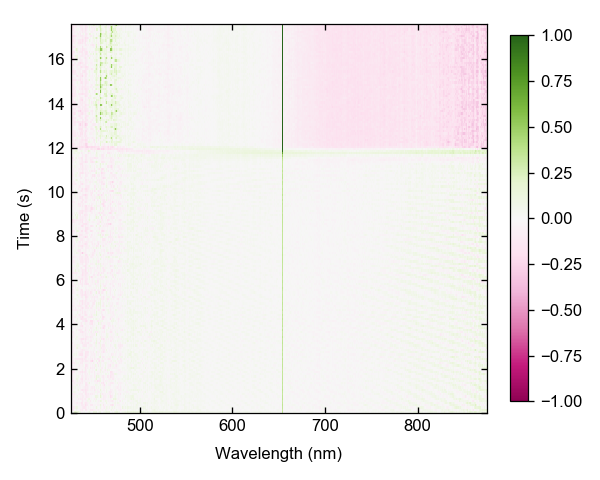

In [55]:
aniso_mat = (-np.log(straight_crop)+np.log(kicked_crop))/(-np.log(straight_crop)-np.log(kicked_crop))

plt.figure(figsize=(5,4))
plt.imshow(aniso_mat,
                origin='lower', aspect='auto',
                vmin=-1, vmax=1,
                interpolation='nearest',
                cmap='PiYG',
                extent=extent_wli)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Time (s)')
plt.colorbar(fraction=0.04, pad=0.05).ax.tick_params(axis='y', direction='out')

## Finally, plot xray and aniso side-by-side

<IPython.core.display.Javascript object>


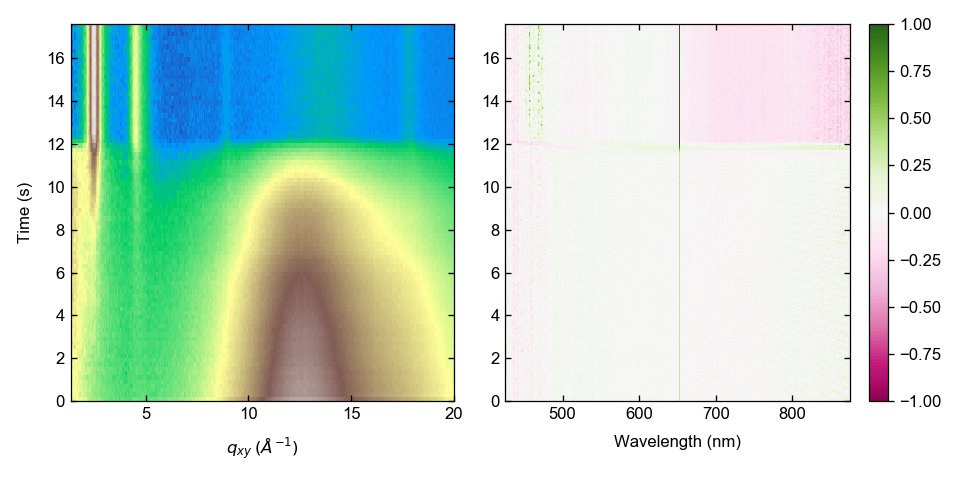

C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [56]:
f2 = plt.figure(figsize=(8,4))

ax21 = plt.subplot(121)
plt.imshow(log_sect_crop,
            origin='lower', aspect='auto',
            vmin=vminx, vmax=vmaxx,
            interpolation='nearest',
            cmap='terrain',
            extent=extent_xray)

plt.xlabel(r'$q_{xy} \: (\AA^{-1})$')
plt.ylabel('Time (s)')

ax22 = plt.subplot(122, sharey=ax21)
plt.imshow(aniso_mat,
            origin='lower', aspect='auto',
            vmin=-1, vmax=1,
            interpolation='nearest',
            cmap='PiYG',
            extent=extent_wli)

plt.xlabel('Wavelength (nm)')
plt.colorbar(fraction=0.05, pad=0.05).ax.tick_params(axis='y', direction='out')
xu_file = os.path.join(os.path.split(figfolder)[0],'{}_xu.png'.format(run_name))
plt.savefig(xu_file, dpi=300, bbox_inches='tight')

## Generate spectra images for the movie

Previous cells must have been run for this to work.

Also add a 2-second buffer before blade passage

In [57]:
%matplotlib inline

xray_start_buf = int(xray_start - 2/xray_dt)

for ind,row in df.loc[df['movie_num']==main_movie].loc[df['shot_num'].between(xray_start_buf,xray_stop)].iterrows():

    data_file = row['fullpath']
    data_exp = row['exp_time']
    data = fabio.open(data_file).data
    data = np.flipud(data)
    
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)

    imgt, qxy, qz = pg.transform_reciprocal(data, method='lut', correctSolidAngle=True, unit='A', dark=darkscale)
    corrimg = imgt-np.min(imgt)+1
    logimg = np.log(corrimg)
    
    figpath = os.path.join(figfolder, 'raw_waxs', row['filename'][:-9]+'{0:04d}.png'.format(row['shot_num']-xray_start_buf))
    print(figpath)
    
    clim = np.percentile(logimg, (2.5, 99.8))
    ppl.implot(logimg,qxy,qz,mode='rsma',cmap='terrain',clim=clim,xlim=(-0.2,2),ylim=(-0.05,2),show=False,filename=figpath)
    plt.close()

F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0000.png


C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\pygix-0.1.4a0-py3.6.egg\pygix\plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':
C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0001.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0002.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0003.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0004.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0005.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0006.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0007.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0008.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0009.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0010.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_p

F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0088.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0089.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0090.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0091.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0092.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0093.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0094.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0095.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0096.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_0097.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_p

In [59]:
figwild = figpath[:-8]+"%04d.png"
movieout = os.path.join(figfolder, "waxs_movie.mp4")
print('Paste this into cmd and run:')
# Run this to make the movie in command prompt
print("""F:\\GitHub\\ffmpeg\\bin\\ffmpeg.exe -framerate 5 -i "{}" -c:v libx264 -r 30 -pix_fmt yuv420p -vf scale=720:-2 -y "{}" """.format(figwild,movieout))

Paste this into cmd and run:
F:\GitHub\ffmpeg\bin\ffmpeg.exe -framerate 5 -i "F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_waxs\n22tol20_hi_para_1_3_%04d.png" -c:v libx264 -r 30 -pix_fmt yuv420p -vf scale=720:-2 -y "F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\waxs_movie.mp4" 


In [63]:
%matplotlib inline

spec_start_buf = int(spec_start - 2/uv_dt)
straight_movie = straight_array[:,w_start_ind:w_stop_ind].clip(min=0.1,max=100)/100
kicked_movie = kicked_array[:,w_start_ind:w_stop_ind].clip(min=0.1,max=100)/100

for i in range(spec_start_buf, spec_stop):
    
    uvfigpath = os.path.join(figfolder, 'raw_uv', 'refl_{0:04d}.png'.format(i-spec_start_buf))
    print(uvfigpath)
    
    plt.figure(figsize=(4,4))
    
    plt.plot(waves_crop,straight_movie[i,:],
             waves_crop,kicked_movie[i+kickoff,:])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    ax_temp = plt.gca()
    ax_temp.set_ylim([0,1])
    
    plt.savefig(uvfigpath, dpi=300, bbox_inches='tight')
    plt.close()

F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0000.png


C:\Users\nep1\anaconda3\envs\xray\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0001.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0002.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0003.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0004.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0005.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0006.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0007.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0008.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0009.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0010.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0011.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0012.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0013.png

F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0108.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0109.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0110.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0111.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0112.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0113.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0114.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0115.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0116.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0117.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0118.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0119.png
F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_0120.png

In [61]:
uvfigwild = uvfigpath[:-8]+"%04d.png"
uvmovieout = os.path.join(figfolder, "uv_movie.mp4")
print('Paste this into cmd and run:')
# Run this to make the movie in command prompt
print("""F:\\GitHub\\ffmpeg\\bin\\ffmpeg.exe -framerate 10 -i "{}" -c:v libx264 -r 30 -pix_fmt yuv420p -vf scale=720:-2 -y "{}" """.format(uvfigwild,uvmovieout))

Paste this into cmd and run:
F:\GitHub\ffmpeg\bin\ffmpeg.exe -framerate 10 -i "F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\raw_uv\refl_%04d.png" -c:v libx264 -r 30 -pix_fmt yuv420p -vf scale=720:-2 -y "F:\N2200 Project\figures\chess_apr18\n22tol20_hi_para_1\uv_movie.mp4" 


### Run peak fits over sectors starting from 88 back to 5 deg.
Initialize each fit from previous parameters

### Perform composite peak fits

In [ ]:
p100 = {'name': 'p100', 'set':1, 'cent': 2.3, 'min': 2.0, 'max': 3.0, 'sig': 0.1, 'amp': 1000, 'lb': 1.5, 'ub': 3.8}

p001 = {'name': 'p001', 'set':2, 'cent': 4.5, 'min': 4.0, 'max': 4.7, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}
p200 = {'name': 'p200', 'set':2, 'cent': 4.9, 'min': 4.7, 'max': 5.5, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}

p300 = {'name': 'p300', 'set':4, 'cent': 7.4, 'min': 7.0, 'max': 8.0, 'sig': 0.1, 'amp': 10, 'lb': 6.4, 'ub': 19.5}

p001a ={'name': 'p001a','set':4, 'cent': 8.8, 'min': 8.6, 'max': 9.0, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 19.5}
p002 = {'name': 'p002', 'set':4, 'cent': 9.5, 'min': 9.3, 'max': 9.8, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}
p400 = {'name': 'p400', 'set':4, 'cent': 9.9, 'min': 9.7, 'max': 10.3, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}

phalo ={'name': 'phalo', 'set':4, 'cent': 14, 'min': 12, 'max': 15, 'sig': 0.2, 'amp': 10, 'lb': 14, 'ub': 19.5}
p010 = {'name': 'p010', 'set':4, 'cent': 16.0, 'min': 15.2, 'max': 16.5, 'sig': 0.1, 'amp': 10, 'lb': 14, 'ub': 19.5}
p002a ={'name': 'p002a','set':4, 'cent': 17.7, 'min': 17.2, 'max': 18, 'sig': 0.1, 'amp': 10, 'lb': 14, 'ub': 19.5}

df = pd.DataFrame.from_dict([p100,p001,p200,p300,p001a,p400,phalo,p010,p002a]) #p002
df

In [ ]:
x = q_sect
y = int_sect
color_list = ['#3cb44b','#0082c8','#f58231','#911eb4','#800000','#000080','#808000']
f1 = plt.figure()
plt.semilogy(x, y, 'r-')

for i in df['set'].unique():
    
    df_peaks = df.loc[df.set==i]
    
    # Build bounded x and y vectors
    lb = df_peaks.iloc[0].lb
    ub = df_peaks.iloc[0].ub
    lb_ind = int(np.where(x>=lb)[0][0])
    ub_ind = int(np.where(x>=ub)[0][0])
    xb = x[lb_ind:ub_ind]
    yb = y[lb_ind:ub_ind]
    
    # Initialize Baseline model
    comp_mod = []
    
    if i not in [1,2]:
        lin_mod = ConstantModel(prefix='lin_')
        pars = lin_mod.make_params(c=yb.min())
        comp_mod.append(lin_mod)
    else:
        lin_mod = ExponentialModel(prefix='lin_')
        pars = lin_mod.guess(y,x=x)
        comp_mod.append(lin_mod)

    # Add peaks
    for index, peak in df_peaks.iterrows():
        prefix = peak['name']+'_'
        peak_temp  = VoigtModel(prefix=prefix)
        
        pars.update( peak_temp.make_params())
        pars[prefix+'center'].set(peak['cent'], min=peak['min'], max=peak['max'])
        pars[prefix+'sigma'].set(peak['sig'])
        pars[prefix+'amplitude'].set(peak['amp'], min=0)
        
        comp_mod.append(peak_temp)
    
    # Build composite model
    comp_mod = np.sum(comp_mod)
    out = comp_mod.fit(yb, pars, x=xb)
    params_dict=out.params.valuesdict()
    
    # Store peak features in original dataframe
    for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
        df.loc[df.name==peak,prop] = params_dict[peak+'_'+prop]
    
    # Add peaks to plot
    comps = out.eval_components(x=xb)
    plt.semilogy(xb, out.eval(x=xb), '-', color = color_list[i])
    for c in comps:
        try:
            plt.semilogy(xb, comps[c], '--', color = color_list[i])
        except:
            const_eval = np.ones(xb.shape)*comps[c]
            plt.semilogy(xb, const_eval, '--', color = color_list[i])

# Show the plot
f1.axes[0].set_ylim( bottom=np.min(y)/10, top=np.max(y)*1.3 )
plt.show()

In [ ]:
df_pole = pd.DataFrame()

for d in range(88,6,-2):
    
    print(d)
    
    # Get I vs Q for angle d
    int_sect, q_sect = pg.profile_sector(data, npt=1000, chi_pos=d,
                                     chi_width=4, radial_range=(1.35, 20),
                                     correctSolidAngle=True,
                                     method='lut', dark=dark)
    
    # Run peak fits, initialized from previous fit's parameters
    x = q_sect
    y = int_sect
    
    df_prev = df
    
    for i in df['set'].unique():
        
        df_peaks = df_prev.loc[df.set==i]

        # Build bounded x and y vectors
        lb = df_peaks.iloc[0].lb
        ub = df_peaks.iloc[0].ub
        lb_ind = int(np.where(x>=lb)[0][0])
        ub_ind = int(np.where(x>=ub)[0][0])
        xb = x[lb_ind:ub_ind]
        yb = y[lb_ind:ub_ind]

        # Initialize Baseline model
        comp_mod = []

        if i not in [1,2]:
            lin_mod = ConstantModel(prefix='lin_')
            pars = lin_mod.make_params(c=yb.min())
            comp_mod.append(lin_mod)
        else:
            lin_mod = ExponentialModel(prefix='lin_')
            pars = lin_mod.guess(y,x=x)
            comp_mod.append(lin_mod)

        # Add peaks
        for index, peak in df_peaks.iterrows():
            prefix = peak['name']+'_'
            peak_temp  = VoigtModel(prefix=prefix)

            pars.update( peak_temp.make_params())
            pars[prefix+'center'].set(peak['center'], min=peak['min'], max=peak['max'])
            pars[prefix+'sigma'].set(peak['sigma'])
            pars[prefix+'amplitude'].set(peak['amplitude'], min=0)

            comp_mod.append(peak_temp)

        # Build composite model
        comp_mod = np.sum(comp_mod)
        out = comp_mod.fit(yb, pars, x=xb)
        params_dict=out.params.valuesdict()

        # Store peak features in original dataframe
        for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
            df.loc[df.name==peak,prop] = params_dict[peak+'_'+prop]
        df['chi']=d

    # Store results in pole figure dataframe
    df_pole = df_pole.append(df)

In [ ]:
df_pole[df_pole.name=='p200']

In [ ]:
pole_list

In [ ]:
h200 = [dfp['height'].loc[2] for dfp in df_pole['peaks'].tolist()]
plt.figure()
plt.plot(df_pole['chi'].tolist(),h200)

### Compute d-spacing, Herman's Orientation

In [ ]:
df['d-space']=2*np.pi / df['center'] * 10
df

In [ ]:
def Hermans(ii, chi):
    sin_chi = np.sin(np.deg2rad(chi))
    cos2chi = np.cos(np.deg2rad(chi)) ** 2
    return np.sum(ii * cos2chi * sin_chi) / np.sum(ii * sin_chi)

def interp_nans(data):
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

### Chi-profile, radially integrated, for Herman's calculation

In [ ]:
p200_q = float(df['center'][df['name']=='p200'])

cake, chi = pg.profile_chi(data, npt=200,
                           radial_pos=p200_q, radial_width=.3,
                           chi_range=(-88,88),
                           correctSolidAngle=True,
                           method='lut', dark=dark)

ppl.plot(chi,np.abs(interp_nans(cake) * np.sin(np.deg2rad(chi))),mode='chi')
print('Hermans Orientation Factor: ', Hermans(interp_nans(cake),chi))

### q-chi map, just because it's possible

In [ ]:
intensity, q_abs, chi = pg.transform_polar(data,
                                           npt=(2000, 400), q_range=(0,20),
                                           correctSolidAngle=True,
                                           method='splitpix', dark=dark)

ppl.implot(intensity, q_abs, chi, mode='polar', cmap='terrain', clim=np.percentile(intensity,(0.1,99.5)))

### Generate cropped, processed spectrum for all files

Previous cells must have been run for this to work.

In [ ]:
for ind,row in df.iterrows():
    
    data = fabio.open(row['fullpath']).data
    data = np.flipud(data)
    
    if row['exp_time'] == 30:
        dark = np.flipud(fabio.open(dark30file).data)
    else: 
        dark = np.flipud(fabio.open(dark90file).data)
    
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                         rot1 = rot1, rot2 = rot2, rot3 = rot3,
                         wavelength = wl, sample_orientation = sample_orientation,
                         incident_angle = incident_angle, tilt_angle = tilt_angle,
                         detector=detector)

    imgt, qxy, qz = pg.transform_reciprocal(data, method='lut', correctSolidAngle=True, unit='A', dark=dark)
    logimg = np.log(imgt+1)
    
    figfile = (row['fullpath'].split('.')[:-1][0]+'.png').replace('data','figures')
    print(figfile)
    clim = np.percentile(logimg[logimg>0], (3, 99.99))
    ppl.implot(logimg,qxy,qz,mode='rsma',cmap='terrain',clim=clim,xlim=(-.6,2),ylim=(-.05,2),show=False,filename=figfile)
    plt.close()

### Write a master function to automate analysis

In [ ]:
def analyze_n22(dfrow):
    
    # Open file, get data and dark spectra
    data_file = dfrow['fullpath']
    print(dfrow['filename'])
    data = fabio.open(data_file).data
    data = np.flipud(data)

    if dfrow['exp_time'] == 30:
        dark = np.flipud(fabio.open(dark30file).data)
    else: 
        dark = np.flipud(fabio.open(dark90file).data)
        
        
    # Setup detector and transform
    ### Detector pixel size
    det_pix = [73.242e-6, 73.242e-6]
    detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

    ### Wavelength
    wl = 0.976254e-10

    ### Center-pixel and sample-to-detector distance
    centerx =  1532.42
    centery = data.shape[0]-3034.23   # This is because I had to flip it upside-down
    sdd = 0.339316

    ### Beamcenter from sample view in meters from lower left of detector
    poni1 = centery * det_pix[1]; poni2 = centerx * det_pix[0]

    ### detector rotations from sample view
    rot1 = deldel /180 * np.pi # move detector to right, in-plane angle# in radians
    rot2 = 0.0    /180 * np.pi # move detector down, out-of-plane angle
    rot3 = 0.0    /180 * np.pi # clockwise rotation

    ### Orientations and Angles
    sample_orientation = 1    # 1 is horizontal, 2 is vertical
    incident_angle = dfrow['theta']     # indicent angle in deg
    tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")
    
    ### Initialize the transform
    pg = pygix.Transform(dist = sdd, poni1 = poni1, poni2 = poni2,
                     rot1 = rot1, rot2 = rot2, rot3 = rot3,
                     wavelength = wl, sample_orientation = sample_orientation,
                     incident_angle = incident_angle, tilt_angle = tilt_angle,
                     detector=detector)
    
    # in-plane profile for analysis
    int_in, q_in = pg.profile_ip_box(data, npt=1000, op_pos=0,
                                 op_width=1, ip_range=(1.35, 20),
                                 correctSolidAngle=True,
                                 method='lut', dark=dark)
    
    # Fitting parameters
    p100 = {'name': 'p100', 'set':1, 'cent': 2.3, 'min': 2.2, 'max': 2.6, 'sig': 0.1, 'amp': 1000, 'lb': 1.5, 'ub': 3.8}

    p001 = {'name': 'p001', 'set':2, 'cent': 4.5, 'min': 4.3, 'max': 4.7, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}
    p200 = {'name': 'p200', 'set':2, 'cent': 4.9, 'min': 4.7, 'max': 5.0, 'sig': 0.1, 'amp': 30, 'lb': 3.8, 'ub': 5.7}

    p300 = {'name': 'p300', 'set':3, 'cent': 7.4, 'min': 7.0, 'max': 8.0, 'sig': 0.1, 'amp': 10, 'lb': 6.4, 'ub': 8.3}

    p001a ={'name': 'p001a','set':4, 'cent': 8.8, 'min': 8.6, 'max': 9.0, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}
    p002 = {'name': 'p002', 'set':4, 'cent': 9.5, 'min': 9.3, 'max': 9.8, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}
    p400 = {'name': 'p400', 'set':4, 'cent': 9.9, 'min': 9.7, 'max': 10.3, 'sig': 0.1, 'amp': 10, 'lb': 8.4, 'ub': 11}

    p002a ={'name': 'p002a','set':5, 'cent': 17.7, 'min': 17.2, 'max': 18, 'sig': 0.1, 'amp': 10, 'lb': 16.7, 'ub': 18.7}

    df = pd.DataFrame.from_dict([p100,p001,p200,p300,p001a,p002,p400,p002a])
    
    # Perform Peak Fits
    x = q_in
    y = int_in

    for i in df['set'].unique():

        df_peaks = df.loc[df.set==i]

        # Build bounded x and y vectors
        lb = df_peaks.iloc[0].lb
        ub = df_peaks.iloc[0].ub
        lb_ind = int(np.where(x>=lb)[0][0])
        ub_ind = int(np.where(x>=ub)[0][0])
        xb = x[lb_ind:ub_ind]
        yb = y[lb_ind:ub_ind]

        # Initialize Baseline model
        comp_mod = []
        lin_mod = LinearModel(prefix='lin_')
        pars = lin_mod.make_params(intercept=yb.min(), slope=0)
        comp_mod.append(lin_mod)

        # Add peaks
        for index, peak in df_peaks.iterrows():
            prefix = peak['name']+'_'
            peak_temp  = VoigtModel(prefix=prefix)

            pars.update( peak_temp.make_params())
            pars[prefix+'center'].set(peak['cent'], min=peak['min'], max=peak['max'])
            pars[prefix+'sigma'].set(peak['sig'])
            pars[prefix+'amplitude'].set(peak['amp'], min=0)

            comp_mod.append(peak_temp)

        # Build composite model
        comp_mod = np.sum(comp_mod)
        out = comp_mod.fit(yb, pars, x=xb)
        params_dict=out.params.valuesdict()

        # Store peak features in original dataframe
        for peak, prop in [s.split('_') for s in list(params_dict.keys())]:
            df.loc[df.name==peak,prop] = params_dict[peak+'_'+prop]
            
    # Store results of peak fits in dfrow
    dfrow['peak_fits'] = df
    
    
    # Get Herman's Orientation and store
    p200_q = float(df['center'][df['name']=='p200'])
    
    cake, chi = pg.profile_chi(data, npt=200,
                               radial_pos=p200_q, radial_width=.3,
                               chi_range=(3,88),
                               correctSolidAngle=True,
                               method='lut', dark=dark)
    
    dfrow['Hermans'] = Hermans(interp_nans(cake),chi)
    
    return dfrow

In [ ]:
df_test = df.iloc[0]
df_test

In [ ]:
res = analyze_n22(df_test)

In [ ]:
df_res = pd.DataFrame()
for i,row in df.iterrows():
    try:
        df_res = df_res.append(analyze_n22(row))
    except:
        pass
    
df_res

In [ ]:
df_res[['filename','solvent','speed','grooves','sample_phi','theta','Hermans']]

In [ ]:
df_res = 

In [ ]:
df_res.to_csv(path_or_buf='n22_waxs_results.csv')

In [ ]:
df_res.to_pickle('n22_waxs_pickle')

In [ ]:
df_new = pd.read_pickle('n22_waxs_pickle')
df_new

In [ ]:
df_new